In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#train_data = pd.read_csv('/content/drive/MyDrive/metin_madenciligi_proje/preprocessed_european_comments_train.csv')
#train_data_new = train_data[train_data['body'].notnull()]

#test_data = pd.read_csv("/content/drive/MyDrive/metin_madenciligi_proje/preprocessed_european_comments_test.csv")
#test_data_new = test_data[test_data['body'].notnull()]

data = pd.read_csv('/content/drive/MyDrive/ColabData/twitter_2018_rahip_brunson/preprocessed_twitter_2018_rahip_brunson.csv')

In [4]:
data.head()

,Unnamed: 0,tweet,Subjectivity,Polarity,Analysis
0,0,"gold settles higher recent downdraft, inflatio...",0.283333,0.116667,Positive
1,1,gloves wedding lace ivory bridalgown weddingdr...,0.600000,0.500000,Positive
2,2,boston happening tomorrow _music!! tickets now...,0.602273,-0.306818,Negative
3,3,"第一商品金地金参考価格(1kg税込) 8:45現在 販売 4,784,000円 買取 4,7...",0.000000,0.000000,Neutral
4,4,"gold gains 1 percent dollar retreat, short-cov...",0.000000,0.000000,Neutral


In [5]:
#combined_data = train_data.append(test_data, ignore_index=True)
data.shape

(45600, 5)

In [6]:
data["Analysis"].value_counts()

Neutral     20999
Positive    17748
Negative     6853
Name: Analysis, dtype: int64

In [7]:
tokenized_data = data['tweet'].apply(lambda x: str(x).split()) # tokenizing

In [8]:
tokenized_data

0        [gold, settles, higher, recent, downdraft,, in...
1        [gloves, wedding, lace, ivory, bridalgown, wed...
2        [boston, happening, tomorrow, _music!!, ticket...
3        [第一商品金地金参考価格(1kg税込), 8:45現在, 販売, 4,784,000円, 買...
4        [gold, gains, 1, percent, dollar, retreat,, sh...
                               ...                        
45595    [looking, low, rate, credit, card?, check, bes...
45596    [federal, reserve, released, non-cash, payment...
45597    [compare, creditcards, best, suits, needs:, fl...
45598    [better, apr, creditcards, cleaning, creditrep...
45599    [value, customers?, protect, credit, card, dat...
Name: tweet, Length: 45600, dtype: object

In [9]:
from gensim.models import Word2Vec

In [10]:
model_w2v = Word2Vec(tokenized_data, size=256,  window=5)
model_w2v.train(tokenized_data, total_examples= len(tokenized_data), epochs=10)

(7673823, 8037910)

In [11]:
model_w2v.wv.most_similar(positive="gold")

[('mastermetals', 0.5953829884529114),
 ('114.64.', 0.5629082918167114),
 ('0.8267%!', 0.5585299730300903),
 ('(gld)', 0.5541887283325195),
 ('colombian', 0.5132622718811035),
 ('champagne', 0.5067177414894104),
 ('powder', 0.49480336904525757),
 ('phonepay', 0.49239829182624817),
 ('shimmer', 0.4874020218849182),
 ('pressed', 0.48183009028434753)]

In [12]:
# EEZ: Exclusive Economic Zone (Münhasır Ekonomik Bölge)
model_w2v.wv.most_similar(positive="exchange")

[('sundstrand', 0.7719022035598755),
 ('eaton', 0.7372512817382812),
 ('remanufactured', 0.735480785369873),
 ('directly', 0.7275052070617676),
 ('foreign', 0.7253440618515015),
 ('hydrostatic', 0.7187299132347107),
 ('iew18', 0.6833939552307129),
 ('dontsleep', 0.6763867139816284),
 ('excavator', 0.6761200428009033),
 ('foreignexchange', 0.6733194589614868)]

In [13]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [14]:
wordvec_arrays = np.zeros((len(tokenized_data), 256))

for i in range(len(data)):
    wordvec_arrays[i,:] = word_vector(tokenized_data[i], 256)

wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

<ipython-input-13-2f6882f45f7b>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += model_w2v[word].reshape((1, size))


(45600, 256)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
#train_w2v = wordvec_df.iloc[:56819,:]
#test_w2v = wordvec_df.iloc[56819:,:]

X_train, x_test, y_train, y_valid = train_test_split(wordvec_df, data['Analysis'],  
                                                          random_state=42, 
                                                          test_size=0.2)

#print(train_w2v.shape, data['Analysis'].shape)

#xtrain_w2v = train_w2v.iloc[y_train.index,:]
#xvalid_w2v = train_w2v.iloc[y_valid.index,:]

In [17]:
X_train.shape

(36480, 256)

In [18]:
x_test.shape

(9120, 256)

In [19]:
y_train.shape

(36480,)

In [20]:
y_train

7388     Positive
6330     Positive
8426      Neutral
768      Positive
17547     Neutral
           ...   
11284    Positive
44732    Positive
38158    Positive
860      Positive
15795    Positive
Name: Analysis, Length: 36480, dtype: object

In [21]:
y_valid.shape

(9120,)

In [22]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray(tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_valid)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['Negative', 'Neutral', 'Positive']

In [23]:
train_labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [24]:
test_labels.shape

(9120, 3)

In [25]:
import tensorflow as tf
import keras.layers as layers
from keras.models import Model
from keras import models
import keras.losses

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input,Embedding,Dense,Flatten
from tensorflow.keras.metrics import AUC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score

epochs = 50
batch_size = 256
optimizer = "adam"
metrics = ["categorical_crossentropy", AUC(name='auc')]

# Build neural network
model = models.Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics= metrics)

history = model.fit(X_train, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(x_test, test_labels))

Epoch 1/50
143/143 [==============================] - 3s 10ms/step - loss: 0.6571 - categorical_crossentropy: 0.6571 - auc: 0.8854 - val_loss: 0.4360 - val_categorical_crossentropy: 0.4360 - val_auc: 0.9513
Epoch 2/50
143/143 [==============================] - 1s 5ms/step - loss: 0.3608 - categorical_crossentropy: 0.3608 - auc: 0.9663 - val_loss: 0.3012 - val_categorical_crossentropy: 0.3012 - val_auc: 0.9756
Epoch 3/50
143/143 [==============================] - 1s 5ms/step - loss: 0.2503 - categorical_crossentropy: 0.2503 - auc: 0.9832 - val_loss: 0.2169 - val_categorical_crossentropy: 0.2169 - val_auc: 0.9866
Epoch 4/50
143/143 [==============================] - 1s 6ms/step - loss: 0.1815 - categorical_crossentropy: 0.1815 - auc: 0.9905 - val_loss: 0.1682 - val_categorical_crossentropy: 0.1682 - val_auc: 0.9911
Epoch 5/50
143/143 [==============================] - 1s 7ms/step - loss: 0.1470 - categorical_crossentropy: 0.1470 - auc: 0.9931 - val_loss: 0.1540 - val_categorical_crossent

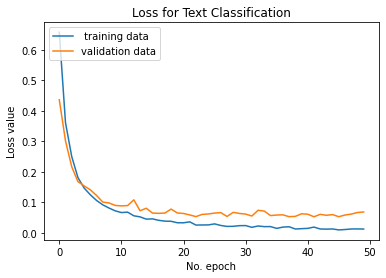

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

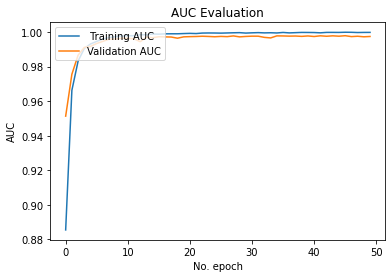

In [27]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [28]:
y__pred = model.predict(x_test)


285/285 [==============================] - 1s 2ms/step


In [29]:
y__pred.shape

(9120, 3)

In [30]:
y__pred = np.where((y__pred == 0),'Negative', y__pred)
y__pred = np.where((y__pred == '1'),'Neutral', y__pred)
y__pred = np.where((y__pred == '2'),'Positive', y__pred)

In [31]:
y_valid.shape

(9120,)

In [32]:
print(classification_report(data.Analysis, y__pred))

ValueError: ignored